### Log Anomlay Detector Core Mininimal Implementation

In an effort to help new users and contributors understand the core Machine Learning elements of the log anomaly detector I have decided to recreate a streamlined minimal version. Here we will ignore any streaming or external aspect of our data and use a fixed local data file for simplicity and reproducability.   

This notebook will cover:
* Log Preprocessing
* Text Encoding
* Model Training
* Generating Anomlay Scores
* Model Inference /Prediction

For the most part function names have been made to match their relevent counter part in the larger code base.

My aim for this notebook is that, by the end a reader will 1) have a clear understanding of how the current implementation works and 2) know where to make changes to try another approach. 

### Import our packages

In [1]:
import os
import time
import numpy as np
import logging
import sompy



from multiprocessing import Pool
from itertools import product
import pandas as pd
import re
import gensim as gs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
%matplotlib inline

### Define our Functions

#### 1. Log Preprocesing

One assumption that all these functions use is that we instantly convert our data into a pandas dataframe that has a "message" column containing the relevent information for us. 

We then treat each individual log line as a "word", cleaning it by removing all non-alphabet charcters including white spaces. 

In [2]:
def _preprocess(data):
    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message)
        else:
            data[col] = data[col].apply(to_str)

    data = data.fillna("EMPTY")
    
def _clean_message(line):
    """Remove all none alphabetical characters from message strings."""
    return "".join(
        re.findall("[a-zA-Z]+", line)
    )  # Leaving only a-z in there as numbers add to anomalousness quite a bit

def to_str(x):
    """Convert all non-str lists to string lists for Word2Vec."""
    ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
    return ret

#### 2. Text Encoding  

Here we employ the gensim implementation of Word2Vec to encode our logs as fixed length numerical vectors. Logs are noteably not the natural usecase for word2vec, but this appraoch attemps to leverage the fact that logs lines themselves, like words, have a context, so encoding a log based on its co-occurence with other logs does make some intuitive sense.

In [3]:
def create(words, vector_length, window_size):
    """Create new word2vec model."""
    w2vmodel = {}
    for col in words.columns:
        if col in words:
            w2vmodel[col] = gs.models.Word2Vec([list(words[col])], min_count=1, size=vector_length, 
                                     window=window_size, seed=42, workers=1, iter=550,sg=0)
        else:
            #_LOGGER.warning("Skipping key %s as it does not exist in 'words'" % col)
            pass
        
    return w2vmodel

def one_vector(new_D, w2vmodel):
    """Create a single vector from model."""
    transforms = {}
    for col in w2vmodel.keys():
        if col in new_D:
            transforms[col] = w2vmodel[col].wv[new_D[col]]

    new_data = []

    for i in range(len(transforms["message"])):
        logc = np.array(0)
        for _, c in transforms.items():
            if c.item(i):
                logc = np.append(logc, c[i])
            else:
                logc = np.append(logc, [0, 0, 0, 0, 0])
        new_data.append(logc)

    return np.array(new_data, ndmin=2)


#### 3. Model Training

Here we employ the SOMPY implementation of the Self-Organizing Map to train our model. This function simply makes it a bit easier for the user to interact with the sompy training requirements. This function returns a trained model.

The trained model object also has a method called codebook.matrix() which allows the user access directly to the trained self organizing map itself. If the map successfull converged then it should consist of nodes in our N-dimensional log space that are well ordered and provide an approximation to the topology of the logs in our training set.

During training we also, compute the distances of our training data to the trained map as a baseline to build a threashold.   

In [4]:
def train(inp, map_size, iterations, parallelism):
    print('training dataset is of size {inp.shape[0]}')
    mapsize = [map_size, map_size]
    np.random.seed(42)
    som = sompy.SOMFactory.build(inp, mapsize , initialization='random')
    som.train(n_job=parallelism, train_rough_len=100,train_finetune_len=5)
    model = som.codebook.matrix.reshape([map_size, map_size, inp.shape[1]])
    
    #distances = get_anomaly_score(inp, 8, model)
    #threshold = 3*np.std(distances) + np.mean(distances)
    
    return som #,threshold

#### 4. Generating Anomaly Scores

One of the key elements of this approach is quantifying the distance between our logs and the nodes on our self organizing map. The two functions below, taken together, represent a parrallel implementation for performing this calculaton.  

In [5]:
def get_anomaly_score(logs, parallelism, model): # for whole dataset 

    parameters = [[x,model] for x in logs]
    pool = Pool(parallelism)
    dist = pool.map(calculate_anomaly_score, parameters) 
    pool.close()
    pool.join()
    #dist = [] 
    #for log in logs:
    #    dist.append(calculate_anomaly_score(log,model))
    
    return dist

def calculate_anomaly_score(parameters): # for a data point 
    log = parameters[0]
    model = parameters[1]
    """Compute a distance of a log entry to elements of SOM."""
    dist_smallest = np.inf
    for x in range(model.shape[0]):
        for y in range(model.shape[1]):
            dist = cosine(model[x][y],log) 
            #dist = np.linalg.norm(model[x][y] - log)
            if dist < dist_smallest:
                dist_smallest = dist
    return dist_smallest


#### 5. Model Inference / Prediction

Here we are making an inference about a new log message. This is done by scoring the incoming log and evaluating whether or not it passess a certain threshold value.  


Ideally our word2vec has been monitoring our application long enough to have seen all the logs. So, if we get a known log we can simply look up its vector representation   

One downside with word2vec is that its quite brittle when it comes to incorporating words that haven't been seen before. In this example, we will retrain the W2Vmodel if our new log has not been seen by the before.  

In [6]:
def infer(w2v, som, log, data, threshold):
    
    log =  pd.DataFrame({"message":log},index=[1])
    _preprocess(log)
    
    if log.message.iloc[0] in list(w2v['message'].wv.vocab.keys()):
        vector = w2v["message"].wv[log.message.iloc[0]]
    else:
        w2v = gs.models.Word2Vec([[log.message.iloc[0]] + list(data["message"])], 
                                 min_count=1, size=100, window=3, seed=42, workers=1, iter=550, sg=0)
        vector = w2v.wv[log.message.iloc[0]]
    
    score = get_anomaly_score([vector], 1, som)
    
    if score < threshold:
        return 0, score
    else:
        return 1, score


### Implementation

First we read in our test dataset and preprocesses. Here was can see this is a rather small example, with 10,000 log lines, but only 3 unique log messages

In [7]:
data_path = "/Users/Yunfei/Desktop/LAD/log_anomaly_detector-10000-events.json"

In [8]:
data = pd.read_json(data_path)


In [9]:
_preprocess(data)
data.head()

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages


In [10]:
data.tail()

,message
9995,DEBUGProcessedoutofpackages
9996,DEBUGProcessedoutofpackages
9997,DEBUGProcessedoutofpackages
9998,DEBUGProcessedoutofpackages
9999,DEBUGProcessedoutofpackages


In [11]:
x = data.message.value_counts()
for i in x.keys():
    print(i, x[i])

(u'DEBUGProcessedoutofpackages', 9786)
(u'ThreadodcsserverINFOComposetypestatedoneComposedone', 213)
(u'rootCMDusrlocalbinmonitorapachestatsshdevnull', 1)


#### Encode our logs

We then create our w2vmodel based on our preprocessed dataset and replace our log lines with thier vectorized representation. 

In [12]:
w2vmodel = create(data, 100,3)

In [13]:
transformed_data = one_vector(data, w2vmodel)
transformed_data = transformed_data[:,1:]

# Implement Local Outlier Factor

Use preprocessed data in local outlier factor model to classify anomaly logs.
Local outlier factor is a density-based method that relies on nearest neighbours search. The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors.

Preselected parameter k is the number of neighbors the LOF calculation is considering. The LOF is a calculation that looks at the neighbors of a certain point to find out its density and compare this to the density of other points. With k defined, the k-distance can be calculated, which is the distance of a point to its kth neighbor.


The k-distance is used to calculate the reachability distance. This distance measure is simply the maximum of the distance of two points and the k-distance of the second point.

$reachability-dist(a,b) = max\{k-distance(b), dist(a,b)\}$


The reach-dist is then used to calculate still another concept — the local reachability density (lrd). To get the lrd for a point a, we will first calculate the reachability distance of a to all its k nearest neighbors and take the average of that number. The lrd is then simply the inverse of that average. 

$lrd(a) = \frac{1}{sum(reach-dist(a,n))/k}$


The lrd of each point will then be compared to the lrd of their k neighbors. More specifically, k ratios of the lrd of each point to its neighboring points will be calculated and averaged. The LOF is basically the average ratio of the lrds of the neighbors of a to the lrd of a. If the ratio is greater than 1, the density of point a is on average smaller than the density of its neighbors and, thus, from point a, we have to travel longer distances to get to the next point or cluster of points than from a’s neighbors to their next neighbors. 

The LOF of a point tells the density of this point compared to the density of its neighbors. If the density of a point is much smaller than the densities of its neighbors (LOF ≫1), the point is far from dense areas and, hence, an outlier.

References:
Breunig, M. M., Kriegel, H. P., Ng, R. T., & Sander, J. (2000, May). LOF: identifying density-based local outliers. In ACM sigmod record (Vol. 29, №2, pp. 93–104). ACM.

In [45]:
type(transformed_data) #numpy.ndarray
#transformed_data.shape #(10000, 100)

numpy.ndarray

In [15]:
#unique0, counts0 = np.unique(transformed_data, return_counts=True)
#dict(zip(unique0, counts0))

# Parameter Selection
Various value of K is tried in the model. 
When k<213, the classification result is 1:9999
When k>=213, the classification result is 214:9786

Since in the dataset, 9786 data points are in one cluster, 213 points in one cluster, and 1 point by itself.

To better detect outlier, k is selected as 300.



In [32]:
from sklearn.neighbors import LocalOutlierFactor
print(__doc__)

X=transformed_data
clf = LocalOutlierFactor(n_neighbors=300, metric='euclidean')
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_


Automatically created module for IPython interactive environment


In [19]:
X_scores.shape

(10000,)

In [33]:
#type(y_pred)#numpy.ndarray
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{-1: 214, 1: 9786}

# Dimension Reduction 
Since the dimension of the feature is large, we cannot visualize it. PCA is used to reduce dimension of data.

The number of PCA component is decided by using the ratio of variance explained by each of the selected components. The first component explained 97% of the variance, the second component explained 2% of the variance, and the third component explaned less than 0.1% of the variance. Therefore, the first two components were selected. 

Same classification result obtained after PCA compared with before PCA. 

In [37]:
#Use PCA to extract key features and visualization 
% matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 


scaler=preprocessing.StandardScaler().fit(X) 
X_transformed=scaler.transform(X) 

print("shape of train data before pca", X_transformed.shape)


N_components=2
Data_pca=PCA(n_components=N_components).fit(X_transformed)
X_pca=Data_pca.transform(X_transformed)

print("shape of train data after pca", X_pca.shape)

('shape of train data before pca', (10000, 100))
('shape of train data after pca', (10000, 2))


In [38]:
unique2, counts2 = np.unique(X_pca, return_counts=True)
dict(zip(unique2, counts2))

{-10.415141674705172: 1,
 -1.458925140620655: 9786,
 -0.016621195113296478: 9786,
 0.08825784412107925: 213,
 67.0772608816358: 213,
 143.8560945809869: 1}

In [43]:
print("variance explained", Data_pca.explained_variance_ratio_ )

('variance explained', array([0.97930106, 0.02069894]))


In [44]:
y_pred_pca = clf.fit_predict(X_pca)
X_scores_pca = clf.negative_outlier_factor_


unique_pca, counts_pca = np.unique(y_pred_pca, return_counts=True)
dict(zip(unique_pca, counts_pca))

{-1: 214, 1: 9786}

# Visualization

The plot visualize the data after PCA. 
The red circles are where the data points are clustered and have higher density. The larger circle on the upper left is a cluster having 9786 points, and the small circle on lower right is the cluster having 213 points. The single point on the lower left is one outlier that does not have any neighbor. 

Since we selected number of neighbors to be 500, in this case, the 213 points cluster would all be considered as outliers. 

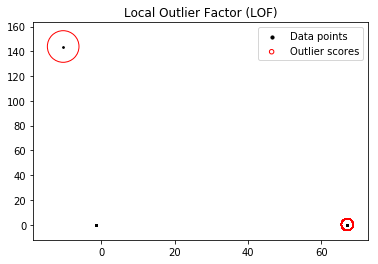

In [41]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores_pca.max() - X_scores_pca) / (X_scores_pca.max() - X_scores_pca.min())
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')

legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

#### Not use following 
#### Train SOM

Here we train the Self Organizing Map on our vectorized logs and output a few vizualiztions of the trained model

In [84]:
map_size = 16
model = train(transformed_data, map_size, 0, 2)

training dataset is of size {inp.shape[0]}


AttributeError: 'module' object has no attribute 'SOMFactory'

In [77]:
from sompy.visualization.hitmap import HitMapView
model.cluster(3)
hits  = HitMapView(10,10,"Clustering",text_size=7)
a=hits.show(model, labelsize=12)

ImportError: No module named visualization.hitmap

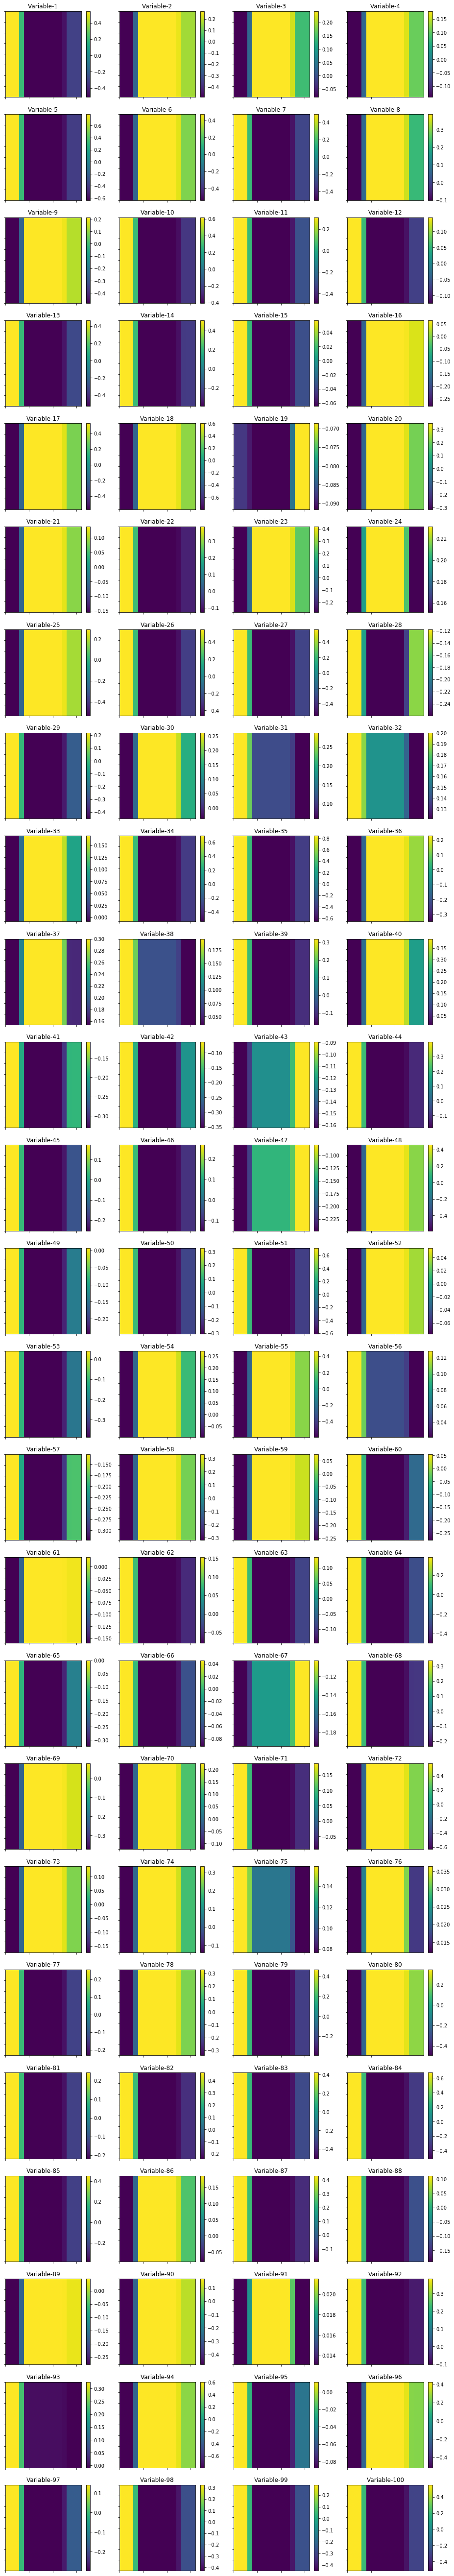

In [16]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(model, col_sz=4, which_dim="all", denormalize=True)

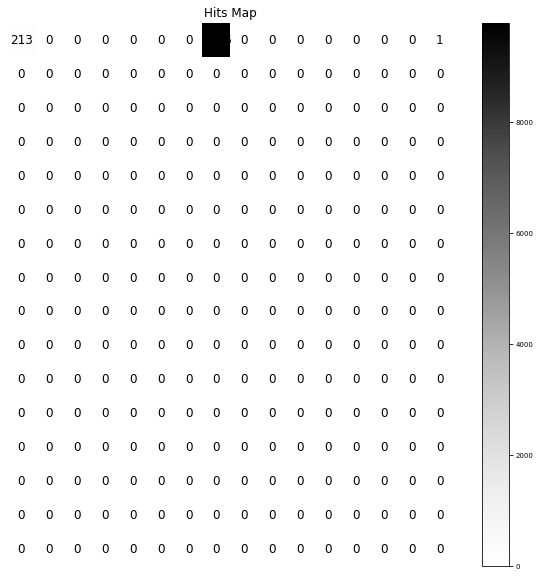

In [17]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
vhts.show(model, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [19]:
 m = model.codebook.matrix.reshape([16, 16, transformed_data.shape[1]])

#### Measure Distances

We want to generate some baseline summary statistics of our model

In [ ]:
#then = time.
distances = get_anomaly_score(transformed_data, 8, m)

print(max(distances))
print(min(distances))
print(np.mean(distances))
print(np.std(distances))

In [ ]:
plt.hist(distances)
plt.show()

In [ ]:
threshold = 3*np.std(distances) + np.mean(distances)
threshold

In [ ]:
threshold

In [ ]:
count = 0
for i, j in enumerate(distances):
    if j > threshold:
        print(j, data.loc[i])
        count += 1
print(count)

In [ ]:
data.message.value_counts()

#### Test 

In [ ]:
infer(w2vmodel,m,'rootCMDusrlocalbinmonitorapachestatsshdevnull', data,threshold)

In [ ]:
infer(w2vmodel,m,'DEBUGProcessedoutofpackages', data,threshold)

In [ ]:
infer(w2vmodel,m,'ThreadodcsserverINFOComposetypestatedoneComposedone ', data,threshold)

In [ ]:
infer(w2vmodel,m,'FSKSDNKSDNKSfdhfhfdhfdhfdhfdhfd  hfhf dlksfljscomLDN', data,threshold)

In [ ]:
infer(w2vmodel,m,'this is not a log message',data,threshold)

In [ ]:
infer(w2vmodel,m,'message',data,threshold)